In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter

Supervised NLP requires a pre-labelled dataset for training and testing, and is generally interested in categorizing text in various ways. In this case, we are going to try to predict whether a sentence comes from _Alice in Wonderland_ by Lewis Carroll or _Persuasion_ by Jane Austen. We can use any of the supervised models we've covered previously, as long as they allow categorical outcomes. In this case, we'll try Random Forests, SVM, and KNN.

Our feature-generation approach will be something called _BoW_, or _Bag of Words_. BoW is quite simple: For each sentence, we count how many times each word appears. We will then use those counts as features.  

In [11]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
bible = gutenberg.raw('bible-kjv.txt')
hamlet = gutenberg.raw('shakespeare-hamlet.txt')
bb = gutenberg.raw('burgess-busterbrown.txt')

# The Chapter indicator is idiosyncratic
bible = re.sub(r'Chapter \d+', '', bible)
hamlet = re.sub(r'Chapter \d+', '', hamlet)
bb = re.sub(r'Chapter \d+', '', bb)
    
hamlet = text_cleaner(hamlet)
bible = text_cleaner(bible)
bb = text_cleaner(bb)

In [13]:
# spacy is bad for you do this the right way
# We need to do the following:
# 1) Compute lemmatization for each text & get all the unique lemmas
# 2) Get the set of common terms across all texts
# 3) Do count vectorization to remove stop words and get a bag-of-words matrix

import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import string
import re

def lemmatize(text):
    
    # Break up text into sentences and then split each sentence into a list of words
    sentenceEnders = re.compile('[.!?]')
    sentenceList = sentenceEnders.split(text)
    word_list = [s.split(' ') for s in sentenceList]

    # Do lemmatization, lower-case conversion, number/punctuation stripping in one shot
    translator_punct = str.maketrans('', '', string.punctuation)
    translator_numbers = str.maketrans('', '', '0123456789')
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatizer_split = [[wordnet_lemmatizer.lemmatize(w.lower().translate(translator_punct).translate(translator_numbers)) 
                        for w in s] for s in word_list]
    
    # Now we compute the set of unique words in the text
    # To do this, we recombine all the lemmas together and then convert to a set to get unique
    sentence_recombined = [" ".join(s) for s in lemmatizer_split]
    text_recombined = " ".join(sentence_recombined)
    unique_word_list = list(set(text_recombined.split(" ")))
    unique_word_list = [u for u in unique_word_list if len(u)>0]
    return sentence_recombined, unique_word_list

# Run alice and persuasion through the lemmatizer
bb_lemmas, bb_words = lemmatize(bb)
hamlet_lemmas, hamlet_words = lemmatize(hamlet)
all_sentences = bb_lemmas + hamlet_lemmas

# Now do count vectorization with stop word removal
cv = CountVectorizer(stop_words='english')  # Will automatically compute unique vocab
X = cv.fit_transform(all_sentences).toarray()
y = ['Burgess'] * len(bb_lemmas) + ['Shakespeare'] * len(hamlet_lemmas)
print(X.shape) # Number of sentences by number of vocab terms
vocab_dict = cv.vocabulary_ # Gets you a mapping of term to column index

# Let's weave into a final dataframe
X_df = pd.DataFrame(X)
X_df['author'] = y
# Can set the columns to the elements of vocab_dict in the correct order if you want

(3384, 5140)


Time to bag some words!  Since spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur.  We will exclude stopwords and punctuation.  In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

## Trying out BoW

Now let's give the bag of words features a whirl by trying a random forest.

In [15]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
# y = X_df['author']
X = np.array(X_df.drop(['author'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9892870336165497

Test set score: 0.9202363367799113


## BoW with Logistic Regression

Let's try a technique with some protection against overfitting due to extraneous features – logistic regression with ridge regularization (from ridge regression, also called L2 regularization).

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
# print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

Training set score: 0.9737717029922424

Test set score: 0.9261447562776958


Logistic regression performs a bit better than the random forest.  

# BoW with Gradient Boosting

And finally, let's see what gradient boosting can do:

In [18]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.9009974141115626

Test set score: 0.8670605612998523


Looks like logistic regression is the winner, but there's room for improvement.

In [34]:
# Perform cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(lr, X, y, cv=5)

array([0.95427729, 0.92466765, 0.93057607, 0.91715976, 0.92159763])

# tf-idf

In [29]:
import re

# reading in the data, this time in the form of paragraphs
hamlet = gutenberg.paras('shakespeare-hamlet.txt')
# processing
hamlet_paras = []
for paragraph in hamlet:
    para = paragraph[0]
    # removing the double-dash from all words
    para = [re.sub(r'--', '', word) for word in para]
    # Forming each paragraph into a string and adding it to the list of strings.
    hamlet_paras.append(' '.join(para))

print(hamlet_paras[0:4])

['[ The Tragedie of Hamlet by William Shakespeare 1599 ]', 'Actus Primus .', 'Enter Barnardo and Francisco two Centinels .', 'Barnardo .']


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(hamlet_paras, test_size=0.3, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than 50% of  the paragraphs
                             min_df=3, # only use words that appear at least 3x
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
hamlet_paras_tfidf=vectorizer.fit_transform(hamlet_paras)
print("Number of features: %d" % hamlet_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(hamlet_paras_tfidf, test_size=0.3, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 40
Original sentence: Mar .
Tf_idf vector: {'mar': 1.0}


In [31]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 40to 39.
svd= TruncatedSVD(39)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 99.92201080577465
Component 0:
Ham .    1.0
Ham .    1.0
Ham .    1.0
Ham .    1.0
Ham .    1.0
Ham .    1.0
Ham .    1.0
Ham .    1.0
Ham .    1.0
Ham .    1.0
Name: 0, dtype: float64
Component 1:
King .    0.999651
King .    0.999651
King .    0.999651
King .    0.999651
King .    0.999651
King .    0.999651
King .    0.999651
King .    0.999651
King .    0.999651
King .    0.999651
Name: 1, dtype: float64
Component 2:
Hor .    1.0
Hor .    1.0
Hor .    1.0
Hor .    1.0
Hor .    1.0
Hor .    1.0
Hor .    1.0
Hor .    1.0
Hor .    1.0
Hor .    1.0
Name: 2, dtype: float64
Component 3:
Laer .    0.999848
Laer .    0.999848
Laer .    0.999848
Laer .    0.999848
Laer .    0.999848
Laer .    0.999848
Laer .    0.999848
Laer .    0.999848
Laer .    0.999848
Laer .    0.999848
Name: 3, dtype: float64
Component 4:
Qu .    1.0
Qu .    1.0
Qu .    1.0
Qu .    1.0
Qu .    1.0
Qu .    1.0
Qu .    1.0
Qu .    1.0
Qu .    1.0
Qu .    1.0
Name: 4, dtype: 

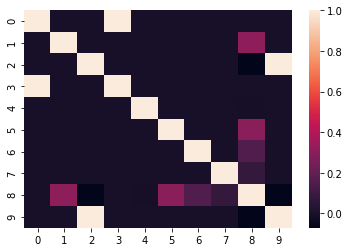

Key:
0 Ham .
1 Rosin .
2 Qu .
3 Ham .
4 Manet Hamlet .
5 Mar .
6 Guild .
7 Enter King , Queene , Rosincrane , and Guildensterne Cum alijs .
8 Other .
9 Qu .


In [32]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])
